# **Authors**

***The work can be done in groups of up to 3 students. Please complete the following fields with your group number and list your names and HDU ID numbers.***

> **[HDU-AT3-25] Computer Vision**
>
> 1. Li Xin, 22320404
> 3. Name, HDU id

The task and guidelines were prepared by Andrei Zhdanov and Sergei Shavetov, ITMO University, 2025.

# **Practical Assignment No 4. Face Detection. Viola-Jones Approach**

***Study of Viola-Jones approach for detection of faces and parts of bodies in images.***

To implement the current practical assignment task we would need OpenCV and NumPy libraries along with image display functions we wrote during the Image Processing class. We import OpenCV's `cv2` library as `cv` for easier use.

In [1]:
# Import OpenCV library as both cv2 and cv
import cv2
import cv2 as cv
# Import NumPy library as np
import numpy as np
# Import functions from our utility library
from pa_utils import ShowImages, exit

# **Introduction**

The Viola-Jones face detector method [1] is based on the following four concepts:
1. Haar-like features as weak classifiers.
2. Integral image representation for fast calculation of Haar-like features.
3. AdaBoost training method to combine weak classifiers into a strong classifier.
4. Combining strong classifiers into a cascade classifier.


## Haar-like Features

Haar-like feature is a kind of weak classifier. It can be defined as the difference of the sum of pixels of areas inside the rectangle, which can be at any position and scale within the original image. In a traditional Viola-Jones face detector algorithm 4 types of Haar-like features that are shown in Fig. 1 are used. 

First of all, we have to understand what these features are. Let us look at Fig. 1.

| ![Haar-like features used in Viola-Jones face detector](images/pa4_fig1.png "Haar-like features used in Viola-Jones face detector") | 
|:--:| 
| ***Fig. 1.*** *Haar-like features used in Viola-Jones face detector.* |

To calculate the value of the Haar-like feature we need to calculate sums of pixels inside rectangular areas of the image and do it as fast as possible. 

$$
value = \sum{(pixels\ in\ black\ area)} - \sum{(pixels\ in\ white\ area)}.
$$

The straightforward calculation of the sum of pixel values in a rectangle would require the number of addition operations equal to the number of pixels minus one. To speed up the feature calculation, an integral image representation is used. In this representation, each pixel stores the sum of all pixel values positioned to the left and above of the current pixel, see Fig. 2.

| ![Integral image](images/pa4_fig2.png "Integral image") | 
|:--:| 
| ***Fig. 2.*** *Integral image.* |

After the integral image is calculated, to calculate the sum of pixel intensity values in an arbitrary rectangle we need to access only four pixels of an integral image located at the corners of the rectangle, see Fig. 3.

$$
sum = D - B - C + A,
$$

where $D$ is the bottom right corner of the rectangle, $B$ is a pixel one pixel above the top right corner of the rectangle, $C$ is the pixel to one pixel the left of the bottom left corner of the rectangle, and $A$ is a pixel one pixel above and to the left of the top left corner of the rectangle.

| ![Rectangular sum calculation with an integral image](images/pa4_fig3.png "Rectangular sum calculation with an integral image") | 
|:--:| 
| ***Fig. 3.*** *Rectangular sum calculation with an integral image.* |

The set of Haar-like features (which are weak classifiers) can be combined with a weighted sum of their values to form a more complex strong classifier, see Fig. 4. The training algorithm is called AdaBoost. It consists of several boosting rounds, and each boosting round is a selection of a best weak Haar-like feature to classify the training set taking the classification errors of the previous rounds into account.

| ![Combining weak classifiers into a strong classifier](images/pa4_fig4.png "Combining weak classifiers into a strong classifier") | 
|:--:| 
| ***Fig. 4.*** *Combining weak classifiers into a strong classifier.* |

Formally, the AdaBoost training scheme algorithm can be described with the following steps:


1. On an input we have a training set $T = \{(x_i, y_i) | x_i \in X, y_i \in \{-1,1\}\}$ and a set of all possible weak classifiers $\{h\}$.
2. Initialize the weights for training set items to be equal and sum up to $1$. $D_1(i) = 1 / m$, where $m$ is a number of training set items.
3. Do $K$ iterations:
    1. Choose $h_k$ from a set of weak classifiers $H$, so that the weighted classification error probability is minimal (the probability of the wrong classification with taking weights into account):
    $$
      \epsilon_k = Pr_{i~D_k}[h_k (x_i) \neq y_i].
    $$
    2. Calculate the weight of the currently selected weak classifier based on its classification error probability:
    $$
      \alpha_k = \dfrac{1}{2} \ln \left({\dfrac{1 - \epsilon_k}{\epsilon_k}}\right).
    $$
    3. Reweigh the training set with new weights:
    $$
      D_{k+1} (i) = \dfrac{D_k(i)}{Z_k} \cdot
      \begin{cases}
        e ^ {-\alpha_k}, h_k(x_i) = y_i, \\
        e ^ {\alpha_k}, h_k(x_i) \neq y_i.
      \end{cases}
    $$
4. After completing $K$ iterations build a strong classifier as a weighted sum of weak classifiers that were selected during boosting rounds:
$$
  H(x) = sign \left( \sum_{k=1}^{K} \alpha_k h_k(x) \right).
$$

## Cascade Classifiers

A strong classifier that has a required accuracy may require the calculation of too many weak classifiers that would slow down the detection speed taking into account that most scanned windows do not contain faces. To speed up the detection rate a set of classifiers with increasing complexity are organized in a cascade of classifiers. The cascade contains a set of classifiers with an increasing complexity and detection rate, see Fig. 5.

| ![Cascade classifier](images/pa4_fig5.png "Cascade classifier") | 
|:--:| 
| ***Fig. 5.*** *Cascade classifier.* |

To be classified positively, a sliding window should pass all cascade stages. In case any classifier rejects the window, it is immediately rejected, and the detector proceeds to the next window. As a result, most of the negative windows are rejected fast with the first fast classifiers in the cascade.

The detection rate (true positive rate, TP) of a cascade classifier is a multiplication of detection rates of all classifiers in a cascade:

$$
  TP = \prod_i TP_i.
$$

The false positive rate (FP) is also a multiplication of false positives of cascade classifiers;

$$
  FP = \prod_i FP_i.
$$

As a result, to build a classifier with $0.9$ true positive rate and $10^{-6}$ false negative, each classifier in a cascade should meet the requirement of $0.99$ true positive and just $0.3$ false positive.

Each classifier of the cascade is trained using the AdaBoost training scheme with the requirement to maximize the true positive detection rate while keeping false positives within a given range. The training set is modified between the boosting rounds to increase the complexity of each cascade step.

## References
1. Viola, P., & Jones, M. (2001). Robust real-time object detection. In International Journal of Computer Vision.

# **Task 1. Faces detection**

***Take three arbitrary images containing several faces. Try to use images with a different number of faces and different scales. Perform a search for faces using the Viola-Jones approach. Calculate the number of faces found on each image.***

OpenCV provides a class named `cv2.CascadeClassifier` for cascade classifier execution. Cascade is defined in an *XML* file and can be loaded from a file named `filename` to a classifier object with the `cv2.CascadeClassifier.load(filename)` function. It returns either $True$ or $False$ depending on if the cascade was loaded successfully.

***Notes.*** 
1. The OpenCV library provides some built-in cascade descriptors for faces, eyes, mouths, cat faces, and Russian license plates which can be found in the `data\haarcascades` folder of OpenCV distribution. See [1] for a complete list of built-in cascades. 
2. Other cascade classifiers can be trained using the cascade training tool which is out of the scope of the current practical assignment. You can refer to the `traincascade` OpenCV tool documentation, see [2] for additional information.


### References
1. OpenCV. (2020). OpenCV Haar cascades repository. Retrieved February 1, 2025, from https://github.com/opencv/opencv/tree/4.x/data/haarcascades
2. OpenCV. (2021). Cascade classifier training. Retrieved February 1, 2025, from https://docs.opencv.org/4.x/dc/d88/tutorial_traincascade.html

OpenCV provides several built-in pre-trained cascades for face detection:
- `haarcascade_frontalface_default.xml` is the default $24\times 24$ window size pre-trained adaboost cascade for face detection. It has the higher detection rate but at the same time it has more false-positives.
- `haarcascade_frontalface_alt.xml` is an alternative $20\times 20$ window size pre-trained adaboost cascade for face detection. It has a lower detection rate but also less false-positives.
- `haarcascade_frontalface_alt2.xml` and `haarcascade_frontalface_alt_tree.xml` are two other alternative $20\times 20$ window size pre-trained adaboost cascade with tree-based decision tree.
- `haarcascade_profileface.xml` is a $20\times 20$ window size pre-trained adaboost cascade for profile face detections.

Let us try creating a cascade classifier and loading a default built-in cascade for frontal face detection from a file `haarcascade_frontalface_default.xml`.

In [2]:
# Load a cascade for face
cascade_face_fn = "haarcascades/haarcascade_frontalface_default.xml"
cascade_face = cv.CascadeClassifier()
if cascade_face.load(cv.samples.findFile(cascade_face_fn)):
  print("Face cascade successfully loaded from \"{}\"".format(cascade_face_fn))
else:
  print("Error loading face cascade from \"{}\"".format(cascade_face_fn))
  exit()

Face cascade successfully loaded from "haarcascades/haarcascade_frontalface_default.xml"


After a cascade is loaded it can be applied to an image with `cv2.detectMultiScale(image, scaleFactor, minNeighbors, flags, minSize, maxSize) -> objects` function. This function takes an `image` and applies a previously loaded cascade to detect `objects`. Additional arguments allow specifying optional parameters for object detection:
- `scaleFactor` defines a scale factor between two window sizes when scanning an image with window sizes from `minSize` to `maxSize` (default scale factor is $1.1$);
- `minNeighbors` defines a threshold of how many objects should be found in the same region to consider the detection to be positive, it allows filtering false-positive detections (default threshold is $3$);
- `flags` are not used for Haar cascades, so could be ignored;
- `minSize` and `maxSize` are tuples defining the minimum and maximum size of the window.

There are also two additional functions for multiscale detections that allow to get additional classification parameters, these are:
- `cv2.detectMultiScale2(...) -> objects, numDetections` which allows getting the number of different windows joined together to form the detected objects' location;
- `cv2.detectMultiScale3(..., outputRejectLevels = True) -> objects, rejectLevels, levelWeights` which returns the detection weights which are the certainty of classification at the last stage.

Let us load an image with people and run face detection with the cascade classifier we loaded.

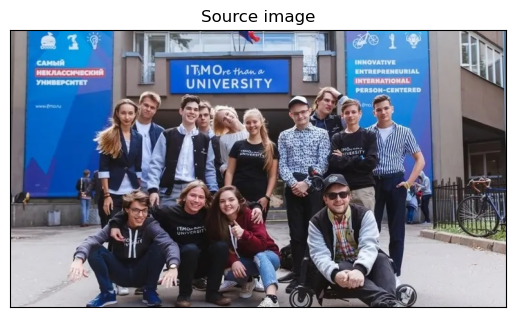

14 faces were detected


In [3]:
# Read an image from a file in BGR
fn = "images/faces.jpg"
I1 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Convert to grayscale
I1gray = cv.cvtColor(I1, cv.COLOR_BGR2GRAY)
# Equalize histogram for a better processing quality
I1gray = cv.equalizeHist(I1gray)

# Display it
ShowImages([("Source image", I1)])

# And detect faces
I1objects = cascade_face.detectMultiScale(I1gray, minNeighbors = 3)

print("{} faces were detected".format(len(I1objects)))

The returned `objects` array stores the list of rectangles for found objects (in our case they are faces). So, we can iterate them all and highlight them on the source image. Also, we can extract faces and display them separately.

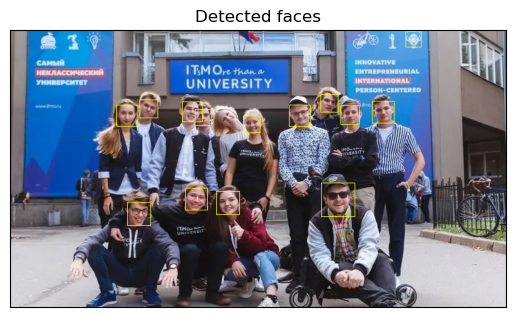

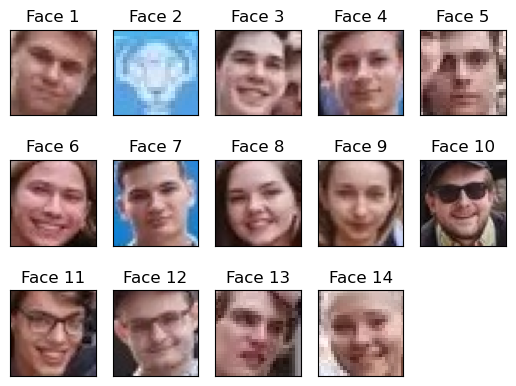

In [4]:
# Highlight faces
I1out = I1.copy()
I1faces = []
for (x, y, w, h) in I1objects:
  # Draw a rectangle on an image to highlight the detected face with a yellow color
  cv.rectangle(I1out, (x, y, w, h), (0, 255, 255), thickness = 1)

  # Extract the face from an image by matrix slicing
  I1face = I1[y : y + h, x : x + w]
  # And add it to the array for displaying
  I1faces.append(("Face {}".format(len(I1faces) + 1), I1face))

# Display it
ShowImages([("Detected faces", I1out)])
ShowImages(I1faces, 5)

As can be seen from the resulting image, almost all faces were detected, except the one that is rotated and could not be classified by a cascade which was not trained to find this type of rotated faces. Also, a false-positive face-like object was detected, however, it's really a face-like one and completely fulfills the cascade requirements.

Let us also get additional information about detected faces, e.g., a detection counter and a certainty for each of them. Since we have to use different functions to get this additional information, we may get different orders of face detections or even different detections. So, we will process detections with counter information and search for a corresponding weight from the second function output.

14 faces were detected


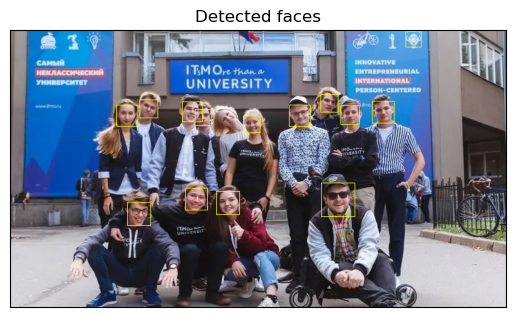

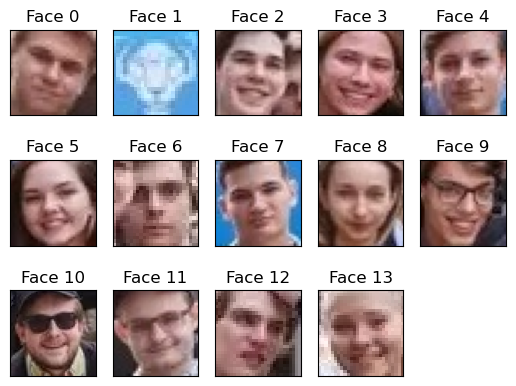

Face  0 detected with   6 windows joined and weight  4.8650
Face  1 detected with   5 windows joined and weight  4.5302
Face  2 detected with  18 windows joined and weight  8.8530
Face  3 detected with  15 windows joined and weight 10.2974
Face  4 detected with  15 windows joined and weight  5.8282
Face  5 detected with  23 windows joined and weight  9.6644
Face  6 detected with   4 windows joined and weight  8.8905
Face  7 detected with  16 windows joined and weight  6.7983
Face  8 detected with  22 windows joined and weight  8.3455
Face  9 detected with  23 windows joined and weight  7.3821
Face 10 detected with  21 windows joined and weight  5.4783
Face 11 detected with   7 windows joined and weight  3.7911
Face 12 detected with   8 windows joined and weight  4.6794
Face 13 detected with   5 windows joined and weight  5.8872


In [5]:
# Detect faces with extra info
# Detect with hits counter
I1objects, I1nums = cascade_face.detectMultiScale2(I1gray, minNeighbors = 3)
# And detect with weights
I1objects_, I1rejects, I1weights = cascade_face.detectMultiScale3(I1gray, minNeighbors = 3, outputRejectLevels = True)
print("{} faces were detected".format(len(I1objects)))

# Process it the same way as before and print the results
# Highlight faces
I1out = I1.copy()
I1faces = []
I1info = []
for i in range(len(I1objects)):
  # Take next face box
  (x, y, w, h) = I1objects[i]
  # And find it in the second array of objects to match them
  # We need this to match hits and weights
  j = np.where((I1objects_ == I1objects[i]).all(axis = 1))
  # If we can't match faces from two detections - ignore this face
  if len(j[0]) != 1:
    print("Something went wrong with face {}, ignoring".format(i))
    continue
  j = j[0][0]

  # Draw a rectangle on an image to highlight the detected face with a yellow color
  cv.rectangle(I1out, (x, y, w, h), (0, 255, 255), thickness = 1)

  # Extract the face from an image by slicing
  I1face = I1[y : y + h, x : x + w]
  # And add it to the array for displaying
  I1faces.append(("Face {}".format(i), I1face))
  I1info.append("Face {:2d} detected with {:3d} windows joined and weight {:7.4f}".format(i, I1nums[i], I1weights[j]))

# Display it
ShowImages([("Detected faces", I1out)])
ShowImages(I1faces, 5)
print("\n".join(I1info))

Now we can see what the criteria for positive choices were. If we increase the `minNeighbors` parameter of the detector we can filter out the false-positive values, however would get more false-negative results as well. This happens due to a set of reasons including the low resolution of the source image.

## **1.1 Self-work**

> ***Self-work***
>
> Take **three** arbitrary images containing several faces. Try to use images with a different number of faces and different scales. Perform a search for faces using the Viola-Jones approach. Calculate the number of found faces on each image. Display the detected faces on the images.
>
> ***Notes.***
> 1. *You may try using some of alternative cascades from the ones listed in these guidelines.*

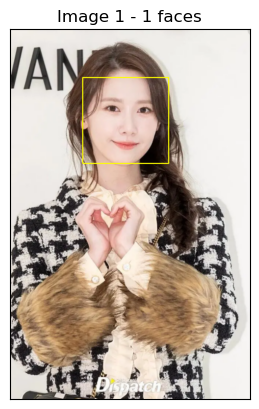

Image 1: 1 faces detected


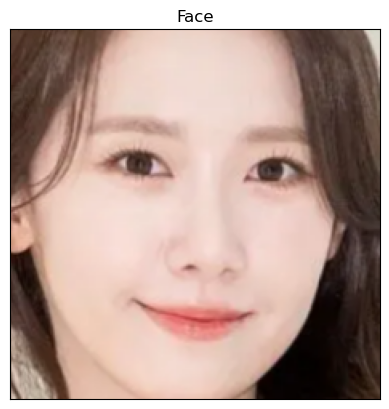

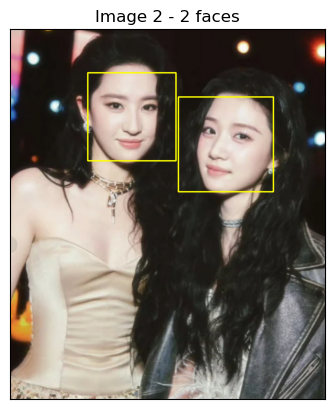

Image 2: 2 faces detected


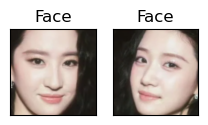

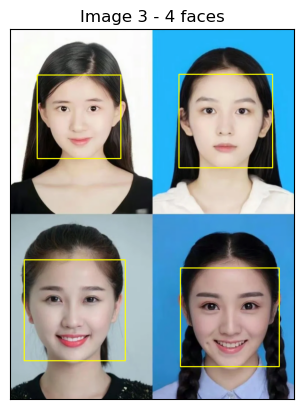

Image 3: 4 faces detected


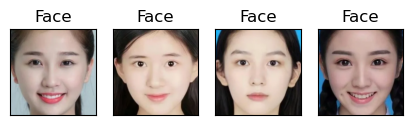

In [6]:

# TODO Place your solution here
def detect_and_display_faces(image_path: str, cascade: cv.CascadeClassifier, title_prefix: str = ""):
    I = cv.imread(image_path, cv.IMREAD_COLOR)
    if I is None:
        print(f"[ERROR] Cannot read image: {image_path}")
        return None

    Igray = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
    Igray = cv.equalizeHist(Igray)

    # 执行检测
    faces = cascade.detectMultiScale(Igray, minNeighbors=10)

    # 绘制检测框
    Iout = I.copy()

    face_thumbs = [] 
    
    for (x, y, w, h) in faces:
        cv.rectangle(Iout, (x, y), (x + w, y + h), (0, 255, 255), 2)

        face_crop = I[y:y+h, x:x+w]
        face_thumbs.append((f"Face", face_crop))

    ShowImages([(f"{title_prefix} - {len(faces)} faces", Iout)])
    
    print(f"{title_prefix}: {len(faces)} faces detected")

    ShowImages(face_thumbs, 5) 
    
cascade_face_fn = "haarcascades/haarcascade_frontalface_default.xml"
cascade_face = cv.CascadeClassifier()

if not cascade_face.load(cascade_face_fn):
    print(f"[ERROR] Failed to load cascade from {cascade_face_fn}")
    exit()



detect_and_display_faces("images/1.1.png", cascade_face, "Image 1")
detect_and_display_faces("images/2.2.png", cascade_face, "Image 2")
detect_and_display_faces("images/3.3.png", cascade_face, "Image 3")



# **Task 2. Body Parts Detection**

***Take three arbitrary images containing several faces. Try to use images with a different number of faces and different scales. Perform to search of at least two parts of bodies in one image (e.g. eyes, mouths, noses). To increase the accuracy use ROI (e.g., upper part of bodies or faces). Calculate the found elements in each category.***

Now let us try to detect eyes on the found face. For this need, we will take a higher-resolution image of a face.

It's obvious that we don't need to scan the whole image for eyes as there would be a lot of false-positive results, so we will define a Region-Of-Interest (ROI) object as a face that was already found and then search for eyes by taking the ROI into an account. With Python, we can define the ROI by simply slicing an array as we already did when displaying the faces found. So, to detect eyes we should:
1. Load a cascade for faces;
2. Use the loaded face cascade to detect faces on the image;
3. Load a cascade for eyes;
4. Go through all detected faces and use the loaded eyes cascade to detect eyes on the face.

**Please note that:**
1. When detecting eyes on the face we use ROI, the returned coordinates are in the face coordinate system and should be recalculated to the image coordinate system to display them on the face as well.
2. The *zero* point of the image coordinate system is the top left corner of the image.
3. When addressing the image array with numpy, the image coordinate system $(x, y)$ is inverted according to matrix rules, so if you want to access the point of an `image` with coordinates $(x, y)$ you should write `image[y, x]`. So,  slicing an ROI window with the given size would be written as:
```python
# Take the rectangle of the next face from the faces array
(x, y, w, h) = faces[i]
# Define an ROI for this rectangle with an array slicing
roi = image[y : y + h, x : x + w]
```

OpenCV provides several cascades which may be used for body parts detections, these are:
- `haarcascade_eye.xml` for eyes detection;
- `haarcascade_eye_tree_eyeglasses.xml` an alternative eyes detection cascade with a higher accuracy and allowing detection of eyes with eyeglasses;
- `haarcascade_lefteye_2splits.xml` for detection of the left eye only;
- `haarcascade_righteye_2splits.xml` for detection of the right eye only;
- `haarcascade_smile.xml` for a smile (or mouth) detection.

And of course there are cascades for a whole body detection:
- `haarcascade_fullbody.xml` for the full body;
- `haarcascade_upperbody.xml` for the upper body;
- `haarcascade_lowerbody.xml` for the lower body.

These cascades can be added to a first stage of detection if you need detect faces of pedestrians. In this case you first have to detect the body and only then use ROI to search for a face.

Let us try this method with the default OpenCV cascade for eyes. Also, now we will use another image with a higher resolution to find eyes on it.

At first, we will run almost the same code as we did before and collect all face information. As a result, we should have:
1. `I2` with source image;
2. `I2out` with source image with faces highlighted;
3. `I2objects` with an array of rectangles for each face on the source image;
4. `I2faces` with an array of tuples with face names and ROI images with the detected faces.

1 faces were detected


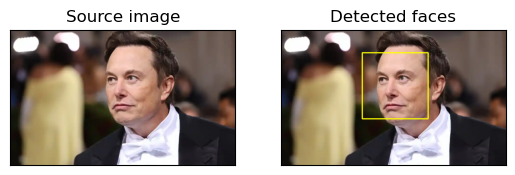

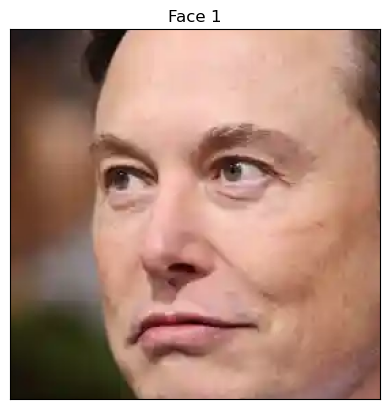

In [7]:
# Read an image from a file in BGR
fn = "images/face.png"
I2 = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I2, np.ndarray) or I2.data == None:
  print("Error reading file \"{}\"".format(fn))
  exit()

# Convert to grayscale
I2gray = cv.cvtColor(I2, cv.COLOR_BGR2GRAY)
# Equalize histogram for a better processing quality
I2gray = cv.equalizeHist(I2gray)

# And detect faces
# Since our image has high resolution, we set a threshold to 10
I2objects = cascade_face.detectMultiScale(I2gray, minNeighbors = 10)
print("{} faces were detected".format(len(I2objects)))

# Highlight faces and search for eyes on each of them
I2out = I2.copy()
I2faces = []
for (x, y, w, h) in I2objects:
  # Draw a rectangle on an image to highlight the detected face with a red color
  cv.rectangle(I2out, (x, y, w, h), (0, 255, 255), thickness = 3)

  # Extract face ROI from an image with slicing
  I2face = I2[y : y + h, x : x + w]

  # And add it to the array for displaying
  I2faces.append(("Face {}".format(len(I2faces) + 1), I2face))

# Display it
ShowImages([("Source image", I2), 
            ("Detected faces", I2out)], 2)
ShowImages(I2faces, 5)

Now we can load the eyes cascade and go through all the detected faces to find eyes and highlight them.

Face cascade successfully loaded from "haarcascades/haarcascade_eye.xml"
3 eyes were detected on face 1


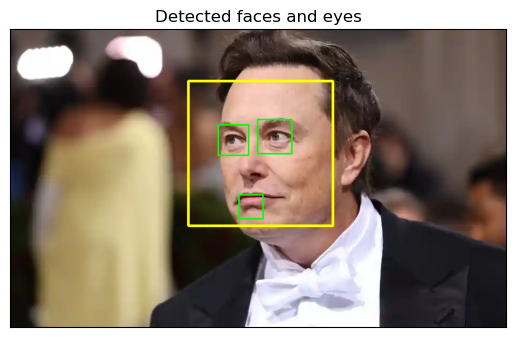

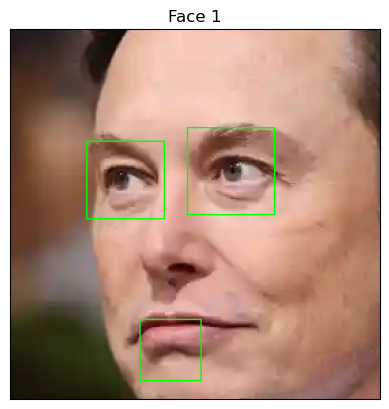

In [8]:
# Load cascade for eyes
cascade_eyes_fn = "haarcascades/haarcascade_eye.xml"
cascade_eyes = cv.CascadeClassifier()
if cascade_eyes.load(cv.samples.findFile(cascade_eyes_fn)):
  print("Face cascade successfully loaded from \"{}\"".format(cascade_eyes_fn))
else:
  print("Error loading face cascade from \"{}\"".format(cascade_eyes_fn))
  exit()

I2out_eyes = I2out.copy()
I2faces_eyes = []

# Go through all faces
for i in range(len(I2objects)):
  # Take face and convert it to grayscale and normalize
  face = I2faces[i][1]
  face = cv.cvtColor(face, cv.COLOR_BGR2GRAY)
  face = cv.equalizeHist(face)

  # Then search for eyes
  I2eyes = cascade_eyes.detectMultiScale(face, minNeighbors = 10)
  print("{} eyes were detected on face {}".format(len(I2eyes), i + 1))

  # Now go through all eyes
  I2face_out = I2faces[i][1].copy()
  for (x, y, w, h) in I2eyes:
    # Highlight them on the face
    cv.rectangle(I2face_out, (x, y, w, h), (0, 255, 0), thickness = 1)
    # And on the source image
    # For this we have to shift eyes by face box position
    # This is (I2objects[i][0], I2objects[i][1])
    cv.rectangle(I2out_eyes, (x + I2objects[i][0], y + I2objects[i][1], w, h), (0, 255, 0), thickness = 2)
    
  I2faces_eyes.append((I2faces[i][0], I2face_out))

# Display it
ShowImages([("Detected faces and eyes", I2out_eyes)], 2)
ShowImages(I2faces_eyes, 5)

As can be seen, some false-positive eye positions were detected. To overcome this problem we can modify the parameters of the cascade (the minimum required number of matches or the scale factor). However, it can be noticed that all false-positives are located at the bottom part of the face, but as you all know eyes are always located at the top $2/3$ of the face, so we can modify the ROI definition taking this into account and search for eyes only in the top $2/3$ part.

Let us do it as well.

2 eyes were detected on the face 1


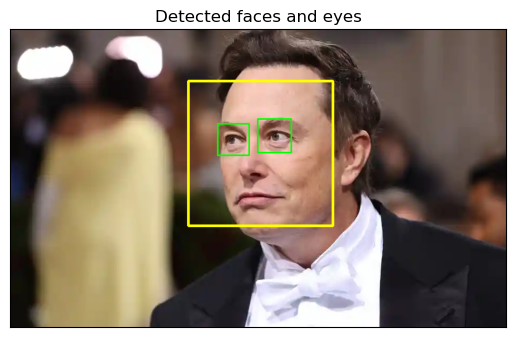

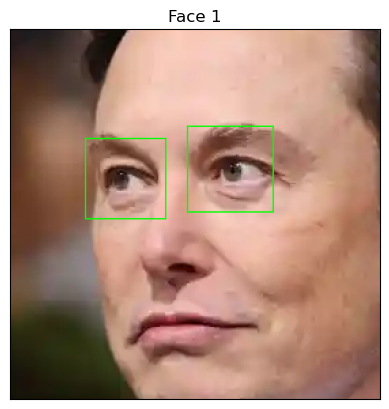

In [9]:
I2out_eyes = I2out.copy()
I2faces_eyes = []

# Go through all faces
for i in range(len(I2faces)):
  # Take face and convert it to grayscale and normalize
  face = I2faces[i][1]
  face = cv.cvtColor(face, cv.COLOR_BGR2GRAY)
  face = cv.equalizeHist(face)

  # Slice the face to take the top 2/3 of a face
  face_roi = face[0: face.shape[0] * 2 // 3, :]

  # Then search for eyes
  I2eyes = cascade_eyes.detectMultiScale(face_roi, minNeighbors = 10)
  print("{} eyes were detected on the face {}".format(len(I2eyes), i + 1))

  # Now go through all eyes
  I2face_out = I2faces[i][1].copy()
  for (x, y, w, h) in I2eyes:
    # Highlight them on the face
    cv.rectangle(I2face_out, (x, y, w, h), (0, 255, 0), thickness = 1)
    # And on the source image
    # For this we have to shift eyes by face box position
    # Since we use the top part of an image the ROI zero point and face zero points are the same point
    # The shift is still (I2objects[i][0], I2objects[i][1])
    cv.rectangle(I2out_eyes, (x + I2objects[i][0], y + I2objects[i][1], w, h), (0, 255, 0), thickness = 2)
    
  I2faces_eyes.append((I2faces[i][0], I2face_out))

# Display it
ShowImages([("Detected faces and eyes", I2out_eyes)], 2)
ShowImages(I2faces_eyes, 5)

The same approach can be used when detecting other parts of the face, for example, the mouth is located at the bottom $1/3$ of the face, so you can define the ROI for mouth detection by slicing a bottom part of the face image matrix.

## **2.1 Self-work**

>  ***Self-work***
>
> Take **three** arbitrary images containing several faces. Try to use images with a different number of faces and different scales. Perform to search of at least two parts of bodies in one image (e.g. eyes, mouths, noses). To increase the accuracy use ROI (upper part of bodies or faces). Calculate the found elements in each category.
>
> ***Notes.***
> 1. *The `haarcascades/haarcascade_smile.xml` file contains the default OpenCV cascade for a mouth.*
> 2. *The mouth is always located at the bottom $1/3$ of the face, you can use it to filter out the false-positive detections.*
> 3. *When highlighting the mouth on the face and the whole image, you should consider that the bottom part of the face has an extra $2/3$ of the face height shift from the zero point of the face and of the whole image.*
> 4. *You may try using other cascades as well, they are listed in these guidelines:*
>     - *`haarcascade_eye.xml` for eyes;*
>     - *`haarcascade_eye_tree_eyeglasses.xml` for eyes with eyeglasses;*
>     - *`haarcascade_lefteye_2splits.xml` for the left eye only;*
>     - *`haarcascade_righteye_2splits.xml` for the right eye only;*
>     - *`haarcascade_smile.xml` for a smile (or mouth).*


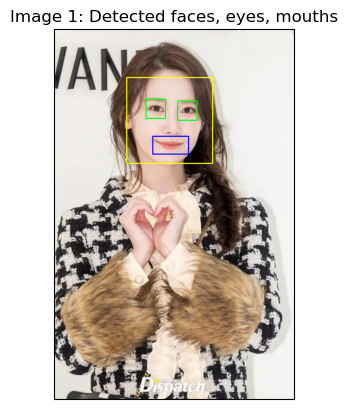

Image 1: 1 faces, 2 eyes, 1 mouths detected


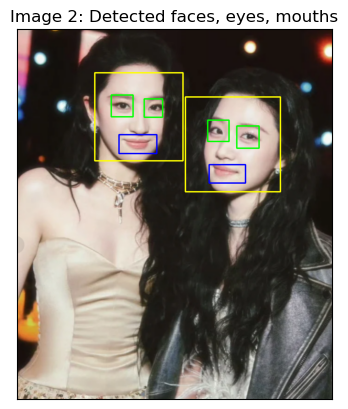

Image 2: 2 faces, 4 eyes, 2 mouths detected


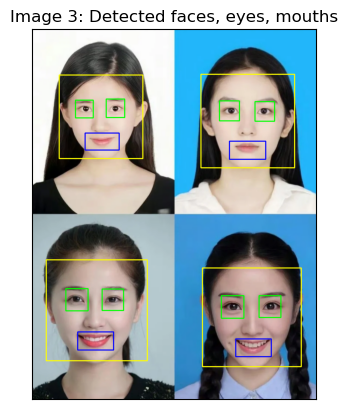

Image 3: 4 faces, 8 eyes, 4 mouths detected


In [10]:
# TODO Place your solution here
def detect_parts_on_image(image_path: str, face_cascade, eye_cascade, mouth_cascade, title_prefix: str = ""):
    I = cv.imread(image_path, cv.IMREAD_COLOR)
    if I is None:
        print(f"[ERROR] Cannot read image: {image_path}")
        return None

    Igray = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
    Igray = cv.equalizeHist(Igray)

    # Haar Cascad检测脸
    faces = face_cascade.detectMultiScale(Igray, minNeighbors=10)

    Iout = I.copy()
    face_regions = []
    eye_count = 0
    mouth_count = 0

    for i, (x, y, w, h) in enumerate(faces):
        # 画脸框
        cv.rectangle(Iout, (x, y), (x + w, y + h), (0, 255, 255), 2)

        face_roi_color = I[y:y+h, x:x+w]
        face_roi_gray = Igray[y:y+h, x:x+w]

        # 眼睛检测
        eyes_roi = face_roi_gray[0:h*2//3, :]
        eyes = eye_cascade.detectMultiScale(eyes_roi, minNeighbors=10)
        for (ex, ey, ew, eh) in eyes:
            cv.rectangle(Iout, (x + ex, y + ey), (x + ex + ew, y + ey + eh), (0, 255, 0), 2)
            eye_count += 1

        #  嘴巴检测
        mouth_roi = face_roi_gray[h*2//3:, :]  
        mouths = mouth_cascade.detectMultiScale(mouth_roi, minNeighbors=10)
        for (mx, my, mw, mh) in mouths:
            # y 坐标加上下偏移（下 1/3 区域）
            my_adjusted = my + h*2//3
            cv.rectangle(Iout, (x + mx, y + my_adjusted), (x + mx + mw, y + my_adjusted + mh), (255, 0, 0), 2)
            mouth_count += 1

        face_regions.append((f"Face {i+1}", face_roi_color))


    ShowImages([(f"{title_prefix}: Detected faces, eyes, mouths", Iout)])
    print(f"{title_prefix}: {len(faces)} faces, {eye_count} eyes, {mouth_count} mouths detected")


face_cascade_fn = "haarcascades/haarcascade_frontalface_default.xml"
eye_cascade_fn = "haarcascades/haarcascade_eye.xml"
mouth_cascade_fn = "haarcascades/haarcascade_smile.xml"

face_cascade = cv.CascadeClassifier()
eye_cascade = cv.CascadeClassifier()
mouth_cascade = cv.CascadeClassifier()

if not face_cascade.load(face_cascade_fn): print("[ERROR] Cannot load face cascade"); exit()
if not eye_cascade.load(eye_cascade_fn): print("[ERROR] Cannot load eye cascade"); exit()
if not mouth_cascade.load(mouth_cascade_fn): print("[ERROR] Cannot load mouth cascade"); exit()


detect_parts_on_image("images/1.1.png", face_cascade, eye_cascade, mouth_cascade, "Image 1")
detect_parts_on_image("images/2.2.png", face_cascade, eye_cascade, mouth_cascade, "Image 2")
detect_parts_on_image("images/3.3.png", face_cascade, eye_cascade, mouth_cascade, "Image 3")

# **Task 3. Optional**

***Implement face detection in a video stream using a pre-recorded video with faces.***

OpenCV provides methods to work with video streams as a set of images. For this, you first have to create an instance of the `cv2.VideoCapture` class.

The following class methods can be used:
- `cv2.VideoCapture.open() -> retval` method is called in the constructor, it allows opening a new video stream (returns $True$ or $False$ - if the stream was opened);
- `cv2.VideoCapture.isOpened() -> retval` method allows checking if the video was successfully loaded (returns $True$ or $False$ - if the stream was opened);
- `cv2.VideoCapture.grab() -> retval` method allows grabbing the next frame for processing to retrieve it (returns $True$ or $False$ - if grabbing succeeds);
- `cv2.VideoCapture.retrieve() -> retval, image` method allows to retrieve the next frame after it finished processing (returns a tuple with success $True$ or $False$ flag and the next frame `image`);
- `cv2.VideoCapture.read() -> retval, image` method grabs and retrieves the next frame in a single call (returns a tuple with success $True$ or $False$ flag and the next frame `image`).
- `cv2.VideoCapture.release()` method releases the video capture device. This function is called automatically in the object destructor or a subsequent opening of a new stream.

In the scope of the current task, you may read video frames with the `read()` function. However, to get a slightly higher performance we may use the combination of `grab()` and `retrieve()` functions.

To display the live video frames, we will use the same OpenCV GUI library we used in the first practical assignment. It will open a separate window and Jupiter cell will keep running until the video window is closed or an ESC button is pressed.


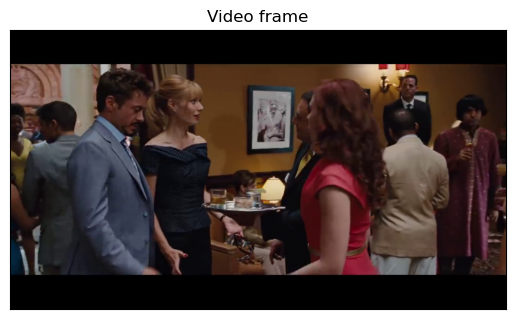

In [11]:
# To open a video from a file just pass the video file name to 
# the VideoCapture class constructor
video = cv.VideoCapture("images/video.mp4")

# Check if a video was opened
if not video.isOpened():
  print("Error opening video capture")
  exit()
# If a video was opened then grab the next frame to process
video.grab()

# Create a window
window_name = "Video stream"
cv.namedWindow(window_name)

# Wait for an ESC key press or window to be closed
while True:
  # Unlike the cv2.waitKey, the cv2.pollKey() function checks 
  # if a key has been pressed without introducing a delay
  if cv.waitKey(1) == 27:
    break
  if cv.getWindowProperty(window_name, cv.WND_PROP_VISIBLE) < 1:
    break

  # While the video is still shown update the window contents
  ret, I = video.retrieve()
  if ret:
    last_frame = I
    cv.imshow(window_name, I)
    video.grab()
  else:
    break

# And destroy all information about the window we used
cv.destroyAllWindows()

# Let us show the last frame here
ShowImages([("Video frame", last_frame)])

Another option to view the video through base64 encoding, for easy viewing.

In [12]:
from IPython.display import display, HTML
import base64

def show_video(video_path):
    video_file = open(video_path, "rb").read()
    video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"
    return HTML(f"""<video width=500 controls><source src="{video_url}"></video>""")

# Использование
show_video("images/video_students.mp4")

If you go to get your video via webcam, you can do it this way. (If you wish)
In order to connect to a camera and process the live video stream you should open the device by its ID. The first video capture device has ID $0$, the second one's ID is $2$, and so on. For example, connecting to the first camera would be written as follows:
```python
# Connect to a camera
video = cv.VideoCapture(0)
```

Note that in the example above, the video was not processed. In the scope of this task, you have to add video processing frame-by-frame and highlight found faces. The Viola-Jones face detection algorithm works quite fast and can be implemented even on low-performance embedded systems hardware, so try tuning the classifier parameters to achieve real-time performance. The `scaleFactor` and window size range are the parameters that affect the algorithm performance most.


## **3.1 Self-work (optional)**

> ***Self-work (optional)***
> 
> Implement face detection in a video stream using a pre-recorded video with faces. Display the live result in a window.

In [13]:

# TODO Place your solution here
face_cascade = cv.CascadeClassifier()
cascade_fn = "haarcascades/haarcascade_frontalface_default.xml"
if not face_cascade.load(cascade_fn):
    print(f"[ERROR] Cannot load cascade from {cascade_fn}")
    exit()

video = cv.VideoCapture("images/video.mp4")
if not video.isOpened():
    print("[ERROR] Cannot open video")
    exit()

window_name = "Live Face Detection"
cv.namedWindow(window_name)

while True:
    ret, frame = video.read()
    if not ret:
        break

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray = cv.equalizeHist(gray)

    #faces = cascade_fn.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

    # for (x, y, w, h) in faces:
    #     cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)

    
    cv.imshow(window_name, frame)

    if cv.waitKey(1) == 27:
        break
    if cv.getWindowProperty(window_name, cv.WND_PROP_VISIBLE) < 1:
        break

video.release()
cv.destroyAllWindows()


 # **Questions**

***Please answer the following questions:***

 - *What is the special image representation used in the Viola-Jones approach?*
 > The integral image representation is used to compute rectangular sums of pixels efficiently.
 >
 >

 - *What is the main advantage of Haar-like features for classifier training?*
 > Haar-like features are simple and fast to compute, which makes training and detection efficient.
 >
 >

 - *Could you use Viola-Jones approach for detecting arbitrary objects and why?*
 > Yes, but only if the object has a consistent appearance and sufficient training data is available.
 >
 >

# **Conclusion**

***What have you learned with this task? Don't forget to conclude it.***

 > We learned how the Viola-Jones method works for real-time face detection using integral images, Haar features, and cascade classifiers. I also implemented detection on images and video files.
 >
 >